In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# NVTabular demo on RecSys2020 Challenge

## Overview

NVTabular is a feature engineering and preprocessing library for tabular data designed to quickly and easily manipulate terabyte scale datasets used to train deep learning based recommender systems.  It provides a high level abstraction to simplify code and accelerates computation on the GPU using the RAPIDS cuDF library.

### RecSys2020 Challenge

The [RecSys](https://recsys.acm.org/) conference is the leading data science conference for recommender systems and organizes an annual competiton in recommender systems. The [RecSys Challenge 2020](https://recsys-twitter.com/), hosted by Twitter, was about predicting interactions of ~200 mio. tweet-user pairs. NVIDIA's team scored 1st place. The team explained the solution in the [blogpost](https://medium.com/rapids-ai/winning-solution-of-recsys2020-challenge-gpu-accelerated-feature-engineering-and-training-for-cd67c5a87b1f) and published the code on [github](https://github.com/rapidsai/deeplearning/tree/main/RecSys2020).

### Downloading the dataset

The dataset has to be downloaded from the original source, provided by Twitter. You need to create an account on the [RecSys Challenge 2020 website](https://recsys-twitter.com/). Twitter needs to (manually) approve your account, which can take a few days. After your account is approved, you can download the data [here](https://recsys-twitter.com/data/show-downloads). We will use only the `training.tsv` file, as we cannot make submissions anymore.

### Learning objectives

This notebook covers the end-2-end pipeline, from loading the original .tsv file to training the models, with NVTabular, [cuDF](https://github.com/rapidsai/cudf), [dask](https://dask.org/) and [XGBoost](https://xgboost.readthedocs.io/). We demonstrate multi-GPU support for NVTabular and new `nvt.ops`, implemented based on the success of our RecSys2020 solution.

1. **NVTabular** to preprocess the original .tsv file.
2. **dask_cudf** to split the preprocessed data into a training and validation set.
3. **NVTabular** to create additional features with only **~70 lines of code**.
4. **dask_cudf** / **XGBoost on GPU** to train our model.

## RecSys2020 Challenge

In [2]:
# External Dependencies
import os
import time
import glob
import gc

import cupy as cp  # CuPy is an implementation of NumPy-compatible multi-dimensional array on GPU
import cudf  # cuDF is an implementation of Pandas-like Dataframe on GPU
import dask  # dask is an open-source library to nateively scale Python on multiple workers/nodes
import dask_cudf  # dask_cudf uses dask to scale cuDF dataframes on multiple workers/nodes

import numpy as np

# NVTabular is the core library, we will use here for feature engineering/preprocessing on GPU
import nvtabular as nvt
import xgboost as xgb

# More dask / dask_cluster related libraries to scale NVTabular
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

from nvtabular.ops import Categorify, DifferenceLag, FillMissing, JoinGroupby, Rename

Let's have a short look on the library versions and setup, we will use.

We ran this example with 2x Quadro GV100 GPUs with each having 32GB of GPU memory. NVTabular used a single GPU whereas XGBoost trained with two GPUs.

In [3]:
time_total_start = time.time()

We define our input directory containing the data, and output directory to save the processed files. 

In [4]:
INPUT_DATA_DIR = os.environ.get("INPUT_DATA_DIR", "/dataset/")
OUTPUT_DIR = os.environ.get("OUTPUT_DIR", "./")

First, we initialize our local cuda cluster.

In [5]:
cluster = LocalCUDACluster(protocol="tcp")
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:43407 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 49.28 GB


## Preparing our dataset

The original data format had multiple inefficiencies, resulting in requiring more disk space and memory:

1. The file format is `.tsv`, an uncompressed, text-based format. The `parquet` file format stores tabular data in a compressed, column-oriented format. This saves a significant amount of disk space which results in fewer i/o operations and faster execution.
2. Some categorical features, such as tweet_id, user_id are hashed to String values (e.g. `cfcd208495d565ef66e7dff9f98764da`). These long Strings require significant amount of disk space/memory. We can encode the Categories as Integer values using `Categorify`. Representing the String `cfcd208495d565ef66e7dff9f98764da` as an Integer `0` can save up 90% in memory. Although other categorical features are no long hashes, they are still Strings (e.g. tweet_type) and we will represent them as Integers, as well.
3. In our experiments, the text_tokens were not a significant feature and we will drop the column before we split the data.

First, we define the column names in the original .tsv file. The .tsv file has no header and we need to specify the names.

In [6]:
features = [
    # Tweet Features
    "text_tokens",
    "hashtags",
    "tweet_id",
    "media",
    "links",
    "domains",
    "tweet_type",
    "language",
    "timestamp",
    # Engaged With User Features
    "a_user_id",
    "a_follower_count",
    "a_following_count",
    "a_is_verified",
    "a_account_creation",
    "b_user_id",
    # Engaging User Features
    "b_follower_count",
    "b_following_count",
    "b_is_verified",
    "b_account_creation",
    "b_follows_a",
    # Engagement Features
    "reply",  # Target Reply
    "retweet",  # Target Retweet
    "retweet_comment",  # Target Retweet with comment
    "like",  # Target Like
]

We define two helper function, we apply in our NVTabular workflow:
1. splitmedia2 splits the entries in media by `\t` and keeps only the first two values (if available),
2. count_token counts the number of token in a column (e.g. how many hashtags are in a tweet),

In [7]:
def splitmedia(col):
    if col.shape[0] == 0:
        return col
    else:
        return (
            col.str.split("\t", expand=True)[0].fillna("")
            + "_"
            + col.str.split("\t", expand=True)[1].fillna("")
        )


def count_token(col, token):
    not_null = col.isnull() == 0
    return ((col.str.count(token) + 1) * not_null).fillna(0)

We will define our data processing pipeline with NVTabular.<br><br>
We count the number of tokens in the columns hashtags, domains, links. We use the `count_token` helper function in a `lambda` function. Finally, we rename the column names to avoid duplicated names.

In [8]:
count_features = (
    nvt.ColumnGroup(["hashtags", "domains", "links"])
    >> (lambda col: count_token(col, "\t"))
    >> Rename(postfix="_count_t")
)

We apply splitmedia function to split the media.

In [9]:
split_media = nvt.ColumnGroup(["media"]) >> (lambda col: splitmedia(col))

We encode categorical columns as a small, continuous integer to save memory. Some categorical columns contain long hashes of type String as values to preserve the privacy of the users (e.g. userId, language, etc.). Long hashes of type String requires significant amount of memory to store. We encode/map the Strings to continuous Integer to save significant memory.
<br><br>
Before we can apply `Categorify`, we need to fill na/missing values in the columns `hashtags`, `domains` and `links`. 

In [10]:
multihot_filled = ["hashtags", "domains", "links"] >> FillMissing()
cat_columns = ["language", "tweet_type", "tweet_id", "a_user_id", "b_user_id"]
cat_features = split_media + multihot_filled + cat_columns >> Categorify(out_path=OUTPUT_DIR)

We want to fill na/missing values in the label columns as well.

In [11]:
label_name = ["reply", "retweet", "retweet_comment", "like"]
label_name_feature = label_name >> nvt.ops.FillMissing()

We extract the weekday from the timestamp.

In [12]:
weekday = (
    nvt.ColumnGroup(["timestamp"])
    >> (lambda col: cudf.to_datetime(col, unit="s").dt.weekday)
    >> nvt.ops.Rename(postfix="_wd")
)

We can visualize our pipeline.

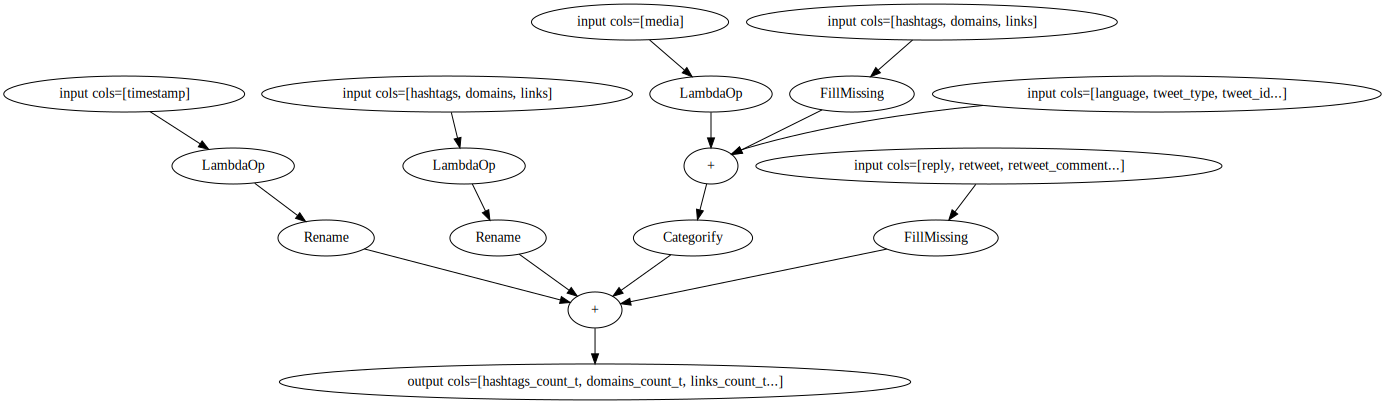

In [13]:
output = count_features + cat_features + label_name_feature + weekday
(output).graph

Our calculation workflow looks correct. But we want to keep columns, which are not used in our pipeline (for `a_follower_count` or `b_follows_a`. Therefore, we include all columns in features, which are not part of our pipeline (except of `text_tokens`).

In [14]:
remaining_columns = [x for x in features if x not in (output.columns + ["text_tokens"])]
remaining_columns

['timestamp',
 'a_follower_count',
 'a_following_count',
 'a_is_verified',
 'a_account_creation',
 'b_follower_count',
 'b_following_count',
 'b_is_verified',
 'b_account_creation',
 'b_follows_a']

We initialize our NVTabular workflow.

In [15]:
proc = nvt.Workflow(output + remaining_columns)

We initialize a nvt.Dataset. The engine is `csv` as the `.tsv` file has a similar structure. The `.tsv` file uses the special character `\x01` to separate columns. There is no header in the file and we define column names with the parameter `names`.

In [16]:
trains_itrs = nvt.Dataset(
    INPUT_DATA_DIR + "training.tsv",
    header=None,
    names=features,
    engine="csv",
    sep="\x01",
    part_size="1GB",
)

First, we collect the training dataset statistics.

In [17]:
%%time

time_preproc_start = time.time()
proc.fit(trains_itrs)
time_preproc = time.time() - time_preproc_start

CPU times: user 1min 11s, sys: 1min 4s, total: 2min 16s
Wall time: 3min 12s


Next, we apply the transformation to the dataset and persist it to disk.<br><br>
We define the output datatypes for continuous columns to save memory. We can define the output datatypes as a dict and parse it to the `to_parquet` function.

In [18]:
dict_dtypes = {}
for col in label_name + [
    "media",
    "language",
    "tweet_type",
    "tweet_id",
    "a_user_id",
    "b_user_id",
    "hashtags",
    "domains",
    "links",
    "timestamp",
    "a_follower_count",
    "a_following_count",
    "a_account_creation",
    "b_follower_count",
    "b_following_count",
    "b_account_creation",
]:
    dict_dtypes[col] = np.uint32

In [19]:
%%time

time_preproc_start = time.time()
proc.transform(trains_itrs).to_parquet(
    output_path=OUTPUT_DIR + "preprocess/", dtypes=dict_dtypes, out_files_per_proc=10
)
time_preproc += time.time() - time_preproc_start

CPU times: user 1min 49s, sys: 1min 42s, total: 3min 31s
Wall time: 4min 40s


We can take a look in the output folder.

## Splitting dataset into training and test

We split the training data by time into a train and validation set. The first 5 days are train and the last 2 days are for validation. We use the weekday for it. The first day of the dataset is a Thursday (weekday id = 3) and the last day is Wednesday (weekday id = 2). Therefore, we split the weekday ids 1 and 2 into the validation set.

In [20]:
%%time

time_split_start = time.time()

df = dask_cudf.read_parquet(os.path.join(OUTPUT_DIR, "preprocess/*.parquet"))
if "text_tokens" in list(df.columns):
    df = df.drop("text_tokens", axis=1)
VALID_DOW = [1, 2]

valid = df[df["timestamp_wd"].isin(VALID_DOW)].reset_index(drop=True)
train = df[~df["timestamp_wd"].isin(VALID_DOW)].reset_index(drop=True)
train = train.sort_values(["b_user_id", "timestamp"]).reset_index(drop=True)
valid = valid.sort_values(["b_user_id", "timestamp"]).reset_index(drop=True)
train.to_parquet(OUTPUT_DIR + "nv_train/")
valid.to_parquet(OUTPUT_DIR + "nv_valid/")
time_split = time.time() - time_split_start

del train
del valid
gc.collect()

CPU times: user 3.04 s, sys: 332 ms, total: 3.37 s
Wall time: 31.5 s


9113

## Feature Engineering 

Now, we can apply the actual feature engineering. We define our data pipelines.

We count encode the columns *media*, *tweet_type*, *language*, *a_user_id*, *b_user_id*. CountEncoding is explained [here](https://github.com/rapidsai/deeplearning/blob/main/RecSys2020Tutorial/03_4_CountEncoding.ipynb).

In [21]:
count_encode = (
    ["media", "tweet_type", "language", "a_user_id", "b_user_id"]
    >> Rename(postfix="_c")
    >> JoinGroupby(cont_cols=["reply"], stats=["count"], out_path="./")
)

We transform timestamp to datetime type.

In [22]:
datetime = nvt.ColumnGroup(["timestamp"]) >> (
    lambda col: cudf.to_datetime(col.astype("int32"), unit="s")
)

We extract hour from datetime.<br>
We extract minute from datetime.<br>
We extract seconds from datetime

In [23]:
hour = datetime >> (lambda col: col.dt.hour) >> Rename(postfix="_hour")
minute = datetime >> (lambda col: col.dt.minute) >> Rename(postfix="_minute")
seconds = datetime >> (lambda col: col.dt.second) >> Rename(postfix="_second")

We difference encode *b_follower_count, b_following_count, language* grouped by *b_user_id*. DifferenceEncoding is explained [here](https://github.com/rapidsai/tdeeplearning/blob/main/RecSys2020Tutorial/05_2_TimeSeries_Differences.ipynb). First, we need to transform the datatype to float32 to prevent overflow/underflow. After DifferenceEncoding, we want to fill NaN values with 0.

In [24]:
diff_lag = (
    nvt.ColumnGroup(["b_follower_count", "b_following_count", "language"])
    >> (lambda col: col.astype("float32"))
    >> DifferenceLag(partition_cols=["b_user_id"], shift=[1, -1])
    >> FillMissing(fill_val=0)
)

We need to transform the LABEL_COLUMNS into boolean (0/1) targets.

In [25]:
LABEL_COLUMNS = ["reply", "retweet", "retweet_comment", "like"]
labels = nvt.ColumnGroup(LABEL_COLUMNS) >> (lambda col: (col > 0).astype("int8"))

We apply TargetEncoding with kfold of 5 and smoothing of 20. TargetEncoding is explained in [here](https://medium.com/rapids-ai/target-encoding-with-rapids-cuml-do-more-with-your-categorical-data-8c762c79e784) and [here](https://github.com/rapidsai/deeplearning/blob/main/RecSys2020Tutorial/03_3_TargetEncoding.ipynb)

In [26]:
target_encode = [
    "media",
    "tweet_type",
    "language",
    "a_user_id",
    "b_user_id",
    ["domains", "language", "b_follows_a", "tweet_type", "media", "a_is_verified"],
] >> nvt.ops.TargetEncoding(
    labels,
    kfold=5,
    p_smooth=20,
    out_dtype="float32",
)

We visualize our NVTabular workflow. 

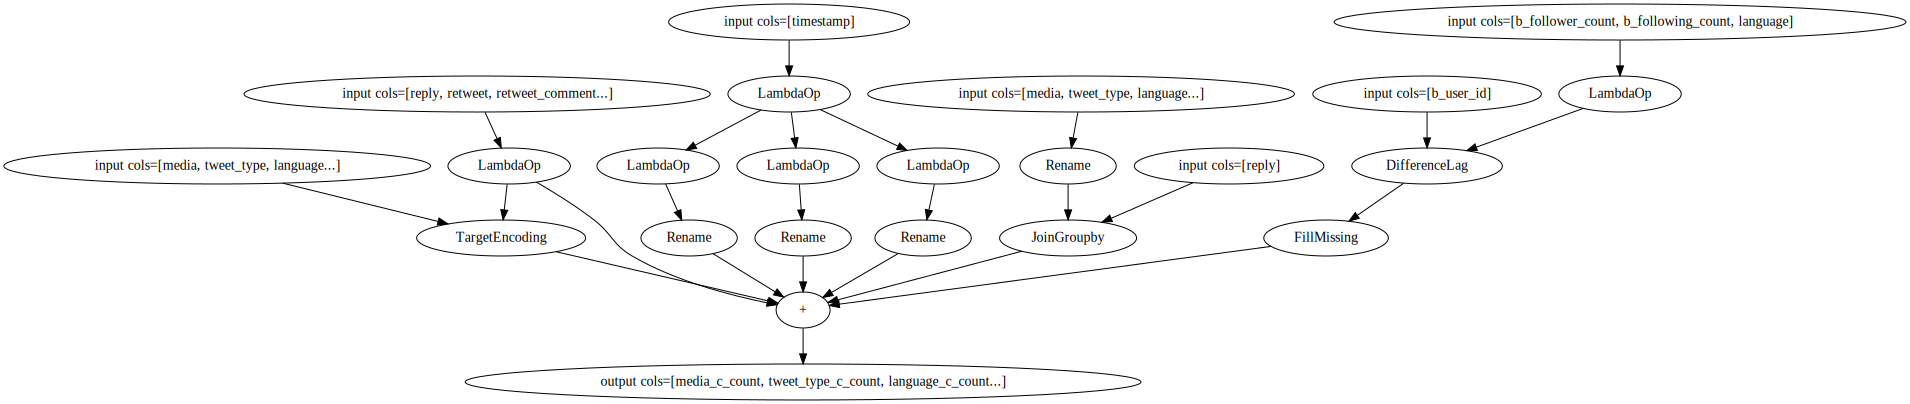

In [27]:
output = count_encode + hour + minute + seconds + diff_lag + labels + target_encode
(output).graph

We want to keep all columns of the input dataset. Therefore, we extract all column names from the first input parquet file.

In [28]:
df_tmp = cudf.read_parquet(OUTPUT_DIR + "/nv_train/part.0.parquet")
all_input_columns = df_tmp.columns
del df_tmp
gc.collect()

37

In [29]:
remaining_columns = [x for x in all_input_columns if x not in (output.columns + ["text_tokens"])]
remaining_columns

['hashtags_count_t',
 'domains_count_t',
 'links_count_t',
 'media',
 'hashtags',
 'domains',
 'links',
 'language',
 'tweet_type',
 'tweet_id',
 'a_user_id',
 'b_user_id',
 'timestamp_wd',
 'timestamp',
 'a_follower_count',
 'a_following_count',
 'a_is_verified',
 'a_account_creation',
 'b_follower_count',
 'b_following_count',
 'b_is_verified',
 'b_account_creation',
 'b_follows_a']

We initialize our NVTabular workflow and add the "remaining" columns to it.

In [30]:
proc = nvt.Workflow(output + remaining_columns)

We initialize the train and valid as NVTabular datasets.

In [31]:
train_dataset = nvt.Dataset(
    glob.glob(OUTPUT_DIR + "nv_train/*.parquet"), engine="parquet", part_size="2GB"
)
valid_dataset = nvt.Dataset(
    glob.glob(OUTPUT_DIR + "nv_valid/*.parquet"), engine="parquet", part_size="2GB"
)

We collect statistics from our train dataset.

In [32]:
%%time

time_fe_start = time.time()
proc.fit(train_dataset)
time_fe = time.time() - time_fe_start

CPU times: user 27.6 s, sys: 10.9 s, total: 38.4 s
Wall time: 42.3 s


The columns *a_is_verified*, *b_is_verified* and *b_follows_a* have the datatype boolean. XGBoost does not support boolean datatypes and we need convert them to int8. We can define the output datatypes as a dict and parse it to the `.to_parquet` function.

In [33]:
dict_dtypes = {}
for col in ["a_is_verified", "b_is_verified", "b_follows_a"]:
    dict_dtypes[col] = np.int8

We apply the transformation to the train and valid datasets.

In [34]:
%%time

time_fe_start = time.time()
proc.transform(train_dataset).to_parquet(
    output_path=OUTPUT_DIR + "nv_train_fe/", dtypes=dict_dtypes
)
proc.transform(valid_dataset).to_parquet(
    output_path=OUTPUT_DIR + "nv_valid_fe/", dtypes=dict_dtypes
)
time_fe += time.time() - time_fe_start

CPU times: user 30.9 s, sys: 44.3 s, total: 1min 15s
Wall time: 1min 20s


## Training our model

After the preprocessing and feature engineering is done, we can train a model to predict our targets. We load our datasets with `dask_cudf`.

In [35]:
train = dask_cudf.read_parquet(os.path.join(OUTPUT_DIR, "nv_train_fe/*.parquet"))
valid = dask_cudf.read_parquet(os.path.join(OUTPUT_DIR, "nv_valid_fe/*.parquet"))

In [36]:
train[["a_is_verified", "b_is_verified", "b_follows_a"]].dtypes

a_is_verified    int8
b_is_verified    int8
b_follows_a      int8
dtype: object

Some columns are only used for feature engineering. Therefore, we define the columns we want to ignore for training.

In [37]:
dont_use = [
    "__null_dask_index__",
    "text_tokens",
    "timestamp",
    "a_account_creation",
    "b_account_creation",
    "hashtags",
    "tweet_id",
    "links",
    "domains",
    "a_user_id",
    "b_user_id",
    "timestamp_wd",
    "timestamp_to_datetime",
    "a_following_count_a_ff_rate",
    "b_following_count_b_ff_rate",
]
dont_use = [x for x in train.columns if x in dont_use]
label_names = ["reply", "retweet", "retweet_comment", "like"]

We drop the columns, which are not required for training.

Our experiments show that we require only 10% of the training dataset. Our feature engineering, such as TargetEncoding, uses the training datasets and leverage the information of the full dataset. In the competition, we trained our models with higher ratio (20% and 50%), but we could not observe an improvement in performance.<br><br>
We sample the training dataset to 10% of the size and drop all columns, which we do not want to use.

In [38]:
SAMPLE_RATIO = 0.1
SEED = 1

if SAMPLE_RATIO < 1.0:
    train["sample"] = train["tweet_id"].map_partitions(lambda cudf_df: cudf_df.hash_encode(stop=10))
    print(len(train))

    train = train[train["sample"] < 10 * SAMPLE_RATIO]
    (train,) = dask.persist(train)
    print(len(train))


Y_train = train[label_names]
(Y_train,) = dask.persist(Y_train)

train = train.drop(["sample"] + label_names + dont_use, axis=1)
(train,) = dask.persist(train)

print("Using %i features" % (train.shape[1]))

87914868
8764882
Using 51 features


Similar to the training dataset, our experiments show that 35% of our validation dataset is enough to get a good estimate of the performance metric. 35% of the validation dataset has a similar size as the test set of the RecSys2020 competition. 

In [39]:
SAMPLE_RATIO = 0.35
SEED = 1
if SAMPLE_RATIO < 1.0:
    print(len(valid))
    valid["sample"] = valid["tweet_id"].map_partitions(lambda cudf_df: cudf_df.hash_encode(stop=10))

    valid = valid[valid["sample"] < 10 * SAMPLE_RATIO]
    (valid,) = dask.persist(valid)
    print(len(valid))

Y_valid = valid[label_names]
(Y_valid,) = dask.persist(Y_valid)

valid = valid.drop(["sample"] + label_names + dont_use, axis=1)
(valid,) = dask.persist(valid)

33471563
13367169


We initialize our XGBoost parameter.

In [40]:
print("XGB Version", xgb.__version__)

xgb_parms = {
    "max_depth": 8,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.3,
    "eval_metric": "logloss",
    "objective": "binary:logistic",
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
}

XGB Version 1.3.3


In [41]:
train, valid = dask.persist(train, valid)

We train our XGBoost models. The challenge requires to predict 4 targets, does a user
1. like a tweet
2. reply a tweet
3. comment a tweet
4. comment and reply a tweet

We train 4x XGBoost models for 300 rounds on a GPU.

In [42]:
%%time
time_train_start = time.time()

NROUND = 300
VERBOSE_EVAL = 50
preds = []
for i in range(4):

    name = label_names[i]
    print("#" * 25)
    print("###", name)
    print("#" * 25)

    start = time.time()
    print("Creating DMatrix...")
    dtrain = xgb.dask.DaskDMatrix(client, data=train, label=Y_train.iloc[:, i])
    print("Took %.1f seconds" % (time.time() - start))

    start = time.time()
    print("Training...")
    model = xgb.dask.train(
        client, xgb_parms, dtrain=dtrain, num_boost_round=NROUND, verbose_eval=VERBOSE_EVAL
    )
    print("Took %.1f seconds" % (time.time() - start))

    start = time.time()
    print("Predicting...")
    preds.append(xgb.dask.predict(client, model, valid))
    print("Took %.1f seconds" % (time.time() - start))

    del model, dtrain

time_train = time.time() - time_train_start

#########################
### reply
#########################
Creating DMatrix...
Took 1.0 seconds
Training...
Took 16.8 seconds
Predicting...


/opt/conda/envs/rapids/lib/python3.8/site-packages/distributed/worker.py:3451: UserWarning: Large object of size 7.93 MB detected in task graph: 
  [<function _predict_async.<locals>.mapped_predict  ... titions>, True]
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


Took 1.8 seconds
#########################
### retweet
#########################
Creating DMatrix...
Took 0.5 seconds
Training...
Took 16.6 seconds
Predicting...
Took 1.7 seconds
#########################
### retweet_comment
#########################
Creating DMatrix...
Took 0.6 seconds
Training...
Took 15.4 seconds
Predicting...
Took 1.3 seconds
#########################
### like
#########################
Creating DMatrix...
Took 0.4 seconds
Training...
Took 16.9 seconds
Predicting...
Took 1.7 seconds
CPU times: user 8.7 s, sys: 1.06 s, total: 9.75 s
Wall time: 1min 14s


In [43]:
yvalid = Y_valid[label_names].values.compute()
oof = cp.array([i.values.compute() for i in preds]).T

In [44]:
yvalid.shape

(13367169, 4)

The hosts of the RecSys2020 competition provide code for calculating the performance metric `PRAUC` and `RCE`. We optimized the code to speed up the calculation, as well. Using cuDF / cupy, we calculate the performance metric on the GPU.

In [45]:
from sklearn.metrics import auc


def precision_recall_curve(y_true, y_pred):
    y_true = y_true.astype("float32")
    ids = cp.argsort(-y_pred)
    y_true = y_true[ids]
    y_pred = y_pred[ids]
    y_pred = cp.flip(y_pred, axis=0)

    acc_one = cp.cumsum(y_true)
    sum_one = cp.sum(y_true)

    precision = cp.flip(acc_one / cp.cumsum(cp.ones(len(y_true))), axis=0)
    precision[:-1] = precision[1:]
    precision[-1] = 1.0

    recall = cp.flip(acc_one / sum_one, axis=0)
    recall[:-1] = recall[1:]
    recall[-1] = 0
    n = (recall == 1).sum()

    return precision[n - 1 :], recall[n - 1 :], y_pred[n:]


def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    recall, prec = cp.asnumpy(recall), cp.asnumpy(prec)

    prauc = auc(recall, prec)
    return prauc


def log_loss(y_true, y_pred, eps=1e-7, normalize=True, sample_weight=None):
    y_true = y_true.astype("int32")
    y_pred = cp.clip(y_pred, eps, 1 - eps)
    if y_pred.ndim == 1:
        y_pred = cp.expand_dims(y_pred, axis=1)
    if y_pred.shape[1] == 1:
        y_pred = cp.hstack([1 - y_pred, y_pred])

    y_pred /= cp.sum(y_pred, axis=1, keepdims=True)
    loss = -cp.log(y_pred)[cp.arange(y_pred.shape[0]), y_true]
    return _weighted_sum(loss, sample_weight, normalize).item()


def _weighted_sum(sample_score, sample_weight, normalize):
    if normalize:
        return cp.average(sample_score, weights=sample_weight)
    elif sample_weight is not None:
        return cp.dot(sample_score, sample_weight)
    else:
        return sample_score.sum()


def compute_rce_fast(pred, gt):
    cross_entropy = log_loss(gt, pred)
    yt = cp.mean(gt).item()
    # cross_entropy and yt are single numbers (no arrays) and using CPU is fast
    strawman_cross_entropy = -(yt * np.log(yt) + (1 - yt) * np.log(1 - yt))
    return (1.0 - cross_entropy / strawman_cross_entropy) * 100.0

Finally, we calculate the performance metric PRAUC and RCE for each target.

In [46]:
txt = ""
for i in range(4):
    prauc = compute_prauc(oof[:, i], yvalid[:, i])
    rce = compute_rce_fast(oof[:, i], yvalid[:, i]).item()
    txt_ = f"{label_names[i]:20} PRAUC:{prauc:.5f} RCE:{rce:.5f}"
    print(txt_)
    txt += txt_ + "\n"

reply                PRAUC:0.13491 RCE:15.57019
retweet              PRAUC:0.50176 RCE:25.95678
retweet_comment      PRAUC:0.04228 RCE:9.24986
like                 PRAUC:0.76676 RCE:23.75791


In [47]:
time_total = time.time() - time_total_start

In [48]:
print("Total time: {:.2f}s".format(time_total))
print()
print("1. Preprocessing:       {:.2f}s".format(time_preproc))
print("2. Splitting:           {:.2f}s".format(time_split))
print("3. Feature engineering: {:.2f}s".format(time_fe))
print("4. Training:            {:.2f}s".format(time_train))

Total time: 848.91s

1. Preprocessing:       472.54s
2. Splitting:           31.39s
3. Feature engineering: 122.55s
4. Training:            74.65s
